In [356]:
import numpy as np
import math
import matplotlib.pyplot as plt

**Constants used in Time Transfer Covariances**

In [357]:
# variables
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5
delta_t = 60
sigma_uere = 0 # can't find a value for this

**Time Transfer Process Covariance (Q)**

The values for h_0, h_m1, and h_m2 were found from DOI - 10.1007/s10291-015-0480-2 in Table 2

These were quite literally the only sources I was able to find on these values.

In [358]:
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

pi = math.pi

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = c*np.array([[e1,e2],[e2,e3]])
print(Q)

[[1.30877395e-12 4.17228686e-16]
 [4.17228686e-16 3.77495000e-16]]


**Time Transfer GPS Measurement Covariance (R)**

Constants were given throughout time transfer paper, however resulting values seem off. Mainly, the psuedorange-rate residual's have a covariance on the order of 10^9. As such we sometimes opt to use R = I

Note: The size of R changes depending on how many satellites are visible to the station, as such we define R as a funcrion of the number of visible satellites (N).

In [359]:
s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T_c)**2)) * (s_pll)


R_paper = lambda N :np.block([[pr_var*np.eye(N,N),np.zeros((N,N))],[np.zeros((N,N)),prr_var*np.eye(N,N)]])
R = lambda N :np.eye(2*N,2*N)

print("Paper Covariance: \n", R_paper(2))
print("----------------------------------------------------")
print("Identity used in testing: \n",R(2))

Paper Covariance: 
 [[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]
----------------------------------------------------
Identity used in testing: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


**Station Information and Update**

We handle each station individually because that is how the algorithms are described and it lets us simulate the parellelism of the true process by telling each station what it's local clock reads at instances A,B,n,B' at the start of each iteration. This is done later in "set_local_times".

In addition to the local times, each station also has a global estimate of time instance n, an id number, it's bias and drift estimates(x), it's estimate covariance (P), the estimates after the cross link updates (psi), and it's nbhr station id's as well as how far away the nbhr station is (Dij = nbhr_dist[j])

Then, each station has it's time update, it's GPS update(a.k.a incremental update), it's cross link update, and it's diffusion update as outlined in the time transfer paper. 

There is also a function second_cross_link which finds the T_g,B' which is shared in the second cross link measurements from the calculated values of psi, T_l,n, and D_ij




**Cross Link Covariance**

We also deal with the cross link covariance here (sigma_j in Eqn 38) . The paper doesn't specify what values they used but when we assumed it was small (0.001) our filter was VERY smug(small estimate covariance), but when we increased it the filter seemed to perform better. It is highlighted below in the cross-link-update function

In [360]:
class Station:
    def __init__(self,id):
        self.local_time = None
        self.global_est = 0 #\hat{T}_g,n
        self.id = id
        self.x = None
        self.P = None
        self.psi_n = None
        self.nbhrs = []
        self.nbhr_dist = {}

    def time_update(self, Q,delta_t = 60):
        # time update steps
        A = np.array([[1, delta_t], [0, 1]])
        self.x = A @ self.x
        self.P = A @ self.P @ A.T + Q

    def incremental_update(self,R,z):
    # Calculate pseudorange/range-rate residuals using Eqs. (23)-(25), add in speed of light
        N = int(len(z)/2)

        C = np.block([
                [np.ones((N, 1)), np.zeros((N, 1))],
                [np.zeros((N, 1)), np.ones((N, 1))]
            ])

        # Update the state and covariance estimate with Eqs. (26)-(28)
        K_n = self.P @ C.T @ np.linalg.inv((C @ self.P @ C.T) + R(N)) # Kalman gain matrix; R defined earlier
        x_hat_n = self.x + (K_n @ (z - C @ self.x))
        P_hat_n = (np.eye(2,2) - K_n @ C) @ self.P

        self.x = x_hat_n
        self.P = P_hat_n

    def crosslink_update(self,nbhr_time_ests,nbhr_cov_ests):
        H = np.array([[1, 0]])
        self.psi_n = np.copy(self.x)
        P_hat_n = np.copy(self.P)
        
        for nbhr_id in self.nbhrs:
            #Eqn 16
            z_jB = c*(self.local_time["B"]-nbhr_time_ests[nbhr_id] - self.nbhr_dist[nbhr_id])

            #Eqn 34
            z_jn = np.array([[z_jB + self.x[1][0]*(self.local_time["n"] - self.local_time["B"])]])
            

            #HERE IS THE CROSS LINK COVARIANCE!!
            sigma_j = 1
            R_j = np.array([[sigma_j + nbhr_cov_ests[nbhr_id][0][0]]])

            K_ij_n = P_hat_n @ H.T @ np.linalg.inv((H @ self.P @ H.T) + R_j)
            self.psi_n = self.psi_n + (K_ij_n @ (z_jn - H @ self.psi_n))
            P_hat_n = (np.eye(2,2) - K_ij_n @ H) @ P_hat_n
        

        self.P = P_hat_n  
          
    #This simulated T_g,B' to send to another station using our T_g,n
    def second_cross_link(self,D_ij):
        return self.local_time["n"] - ((1/c)*self.psi_n[0][0]) + D_ij

    def diffusion_update(self,B,nbhr_time_est):
        #The nbhr_time_est are the T_g,B' from our neighbors
        my_T_hat_g_n = self.local_time["n"] - (1/c)*self.psi_n[0][0]

        #This is our extrapolation of T_g,n from T_g,B"
        T_hat_g_n = {nbhr_id:nbhr_time_est[nbhr_id]+(1-(self.x[1][0]/c))*(self.local_time['n'] - self.local_time['Bp']) for nbhr_id in self.nbhrs}
        
        #Actual DIffusion step
        self.global_est = sum([B[self.id][nbhr_id]*T_hat_g_n[nbhr_id] for nbhr_id in self.nbhrs]+[B[self.id][self.id]*my_T_hat_g_n])
        self.x = np.array([[c*(self.local_time["n"] - self.global_est)],self.x[1]])

**Measurement Simulation**

As opposed to simulating astrodynamics to generate measurements, we instead keep track of the true global time as well as the true bias and drift of each station. With this, we are able to simulate the psuedorange and psuedorange rate residual measurements by simply adding measurement noise, drawn from a zero mean distribution with our measurement covariance (R).

This computation to find the measurements is done below

In [361]:
import time

def measurement_noise(R,N_i):
     return np.linalg.cholesky(R(N_i))@np.random.normal(np.array([[0 for _ in range(2*N_i)]]).T)

def GPS_measurements(true_bias, true_drift,R,N_i = 2):

     true_pr = np.array([[c*(true_bias[0])] for _ in range(N_i)])

     true_prr = np.array([[c*(true_drift[0])] for _ in range(N_i)])

     true_measurements = np.vstack((true_pr,true_prr))

     return true_measurements+measurement_noise(R,N_i)

**Single Filter Iteration**

This is where we simulate a single iteration of our filter. We have a function to setup the filter before the first iteration. This includes giving each station it's initial estimate as well as setting it's neighbors and neighbor distances. 

We also have the aforementioned functions to set the local times at each station. We assume that the algorithms take zero time and each cross link communication takes 3 seconds. We set the local times to match this. 

To run a single iteration of the filter we can set how many satellites are visible to each station (it defaults to 2 per station) and then we set the local times based off the true times and true biases and run each step. We return the measurements so we can plot them later

In [362]:
def filter_initialize(stations,adj_mat,x_initial,P_initial):
  M = len(stations)
  for i in range(M):
    stations[i].x = x_initial[i]
    stations[i].P = P_initial[i]

    for j in range(i+1,M):
        if adj_mat[i][j]!=0:
          stations[i].nbhrs.append(j)
          stations[j].nbhrs.append(i)
          stations[i].nbhr_dist[j] = adj_mat[i][j]
          stations[j].nbhr_dist[i] = adj_mat[i][j]

def new_local_times(true_time,true_bias,true_drift):
   T_A = true_time+true_bias
   T_B = T_A+3+(true_drift*3)
   T_n = T_B
   T_Bp = T_n+3+(true_drift*3)

   return {'A':T_A,'B':T_B,'n':T_n,'Bp':T_Bp}


def diffusion_filter_iteration(stations,Q,R,diff_weights, true_bias, true_drift,true_time,dt,N=None):
    if N is None: N = [2 for _ in range(len(stations))]

    #share first_cross_link

    measurements = []

    for station in stations:
      station.local_time = new_local_times(true_time,true_bias[station.id][0],true_drift[station.id][0])
      time_ests_A = {nbhr_id:stations[nbhr_id].global_est for nbhr_id in station.nbhrs}
      cov_ests_A = {nbhr_id:stations[nbhr_id].P for nbhr_id in station.nbhrs}

      # time update step
      station.time_update(Q,delta_t = dt)

      z = GPS_measurements(true_bias[station.id],true_drift[station.id],R,N[station.id])
      measurements.append(z)
      station.incremental_update(R,z)

      # initialize psi_n with x from step 2 (can choose from step 1 or 2)
      station.psi_n = np.copy(station.x)
      # station.crosslink_update(time_ests_A,cov_ests_A)

    for station in stations:
      time_ests_Bp = {nbhr_id:stations[nbhr_id].second_cross_link(station.nbhr_dist[nbhr_id]) for nbhr_id in station.nbhrs}
      station.diffusion_update(diff_weights, time_ests_Bp)

      #Update from T_g,n to T_g,A by adding time between
      station.global_est += 3
    return measurements

**Filter Simulation**

Since the Coavariances are set above, we simply specify the diffusion weight matrix and the broadcast time matrix as well as the initial estimates and covariances for each station. Here is also where we create and update(with process noise) our true values for time, bias, and drift.

Right now we assume the weights are divided equally and our network topology is 5 nodes aranged in a plus with node 0 being the center

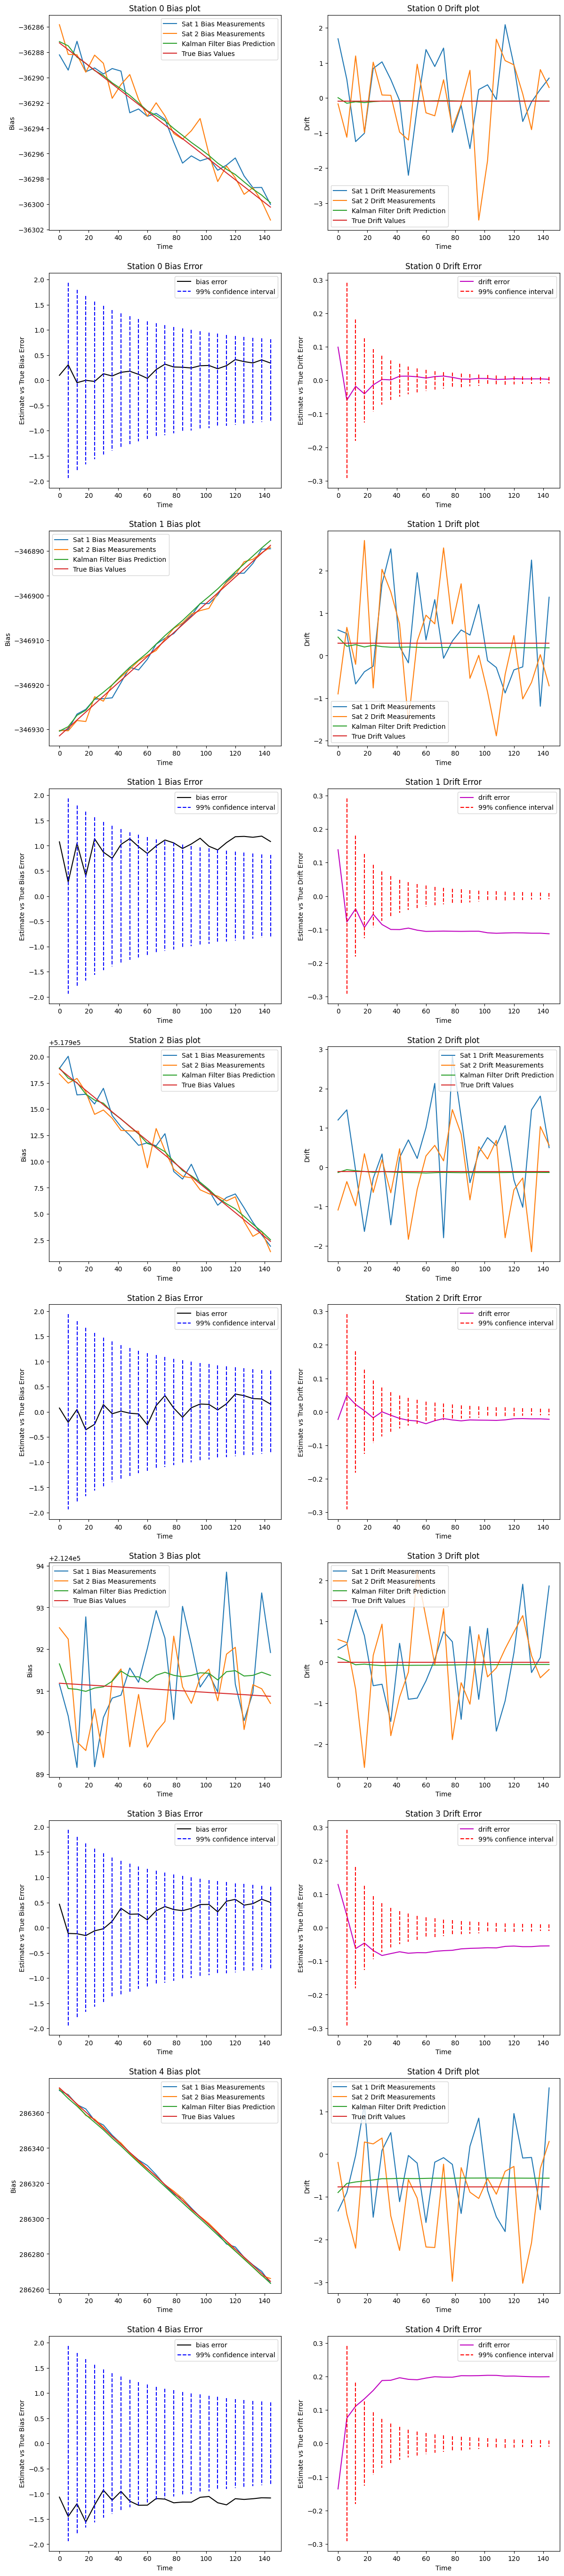

In [363]:

C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
n = len(C[0])


dt = 6
iterations = 25

T_g = 0
true_biases = np.array([[np.random.normal(0,10**(-3)) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,10**(-9)) for _ in range(n)]]).T

def get_station_truth(x,id):
    return np.array([[x[id][0]],[x[n+id][0]]])

x = c*np.vstack((true_biases,true_drifts))

# random initial estimates for each node

x0 = [np.array([[x[i][0]],[x[i+n][0]]]) for i in range(n)]
# x0 = [np.array([[0],[0]]) for _ in range(5)]

P = [np.copy(R(1)) for _ in range(n)]

#Process Noise
procc_noise = lambda : np.linalg.cholesky(Q) @ np.random.normal(np.array([[0,0]]).T)

truth = []
measurements = []
predictions = []
errors = np.zeros((iterations,n,2,1))
P_hist = np.zeros((iterations,n,2,2))

stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)


for i in range(iterations):
    #This gives a pair (bias noise, drift noise) for each station
    noise = np.array([procc_noise().T[0] for _ in range(n)])

    #We reformat the pairs to be added to our truth state vector
    formatted_noise = np.vstack((np.array([noise[:,0]]).T,np.array([noise[:,1]]).T))

    #This is our new truth
    x = np.array([[1,0,0,0,0,dt,0,0,0,0],[0,1,0,0,0,0,dt,0,0,0],[0,0,1,0,0,0,0,dt,0,0],
                  [0,0,0,1,0,0,0,0,dt,0],[0,0,0,0,1,0,0,0,0,dt],[0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1]])@x + formatted_noise
    truth.append(x)

    T_g += 6
    true_biases = [x[:n][i]/c for i in range(n)]
    true_drifts = [x[n:][i]/c for i in range(n)]

    measures = diffusion_filter_iteration(stations,Q,R,C,true_biases,true_drifts,T_g,dt)

    errors[i] = np.array([station.x - get_station_truth(x,station.id) for station in stations])
    measurements.append(measures)
    predictions.append([stn.x for stn in stations])
    P_hist[i] = np.array([station.P for station in stations])

#Number of stations whose plots we are looking at
k = [0,1,2,3,4]

num_rows = 2*len(k)
fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
t_hist = np.arange(0, dt*iterations, dt)
for inx,i in enumerate(k):
    #20 measurements, 2 for each node
    axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in measurements], label = 'Sat 1 Bias Measurements')
    axs[2*inx][0].plot(t_hist,[x[i][1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
    axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
    axs[2*inx][0].plot(t_hist,[x[i][0] for x in truth], label = 'True Bias Values')
    axs[2*inx][0].set_title("Station "+str(i)+" Bias plot")
    axs[2*inx][0].set_xlabel("Time")
    axs[2*inx][0].set_ylabel("Bias")
    axs[2*inx][0].legend()

    axs[2*inx][1].plot(t_hist,[x[i][2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
    axs[2*inx][1].plot(t_hist,[x[i][3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
    axs[2*inx][1].plot(t_hist,[x[i][1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
    axs[2*inx][1].plot(t_hist,[x[i+n][0] for x in truth], label = 'True Drift Values')
    axs[2*inx][1].set_title("Station "+str(i)+" Drift plot")
    axs[2*inx][1].set_xlabel("Time")
    axs[2*inx][1].set_ylabel("Drift")
    axs[2*inx][1].legend()

    

    axs[2*inx+1][0].plot(t_hist, errors[:, i,0,0], 'k', label = "bias error")
    axs[2*inx+1][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([3*np.sqrt(P_hist[1, i,0,0]), -3*np.sqrt(P_hist[1, i, 0,0])]), 'b--', label = "99% confidence interval")
    axs[2*inx+1][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([3*np.sqrt(P_hist[2:, i,0,0]), -3*np.sqrt(P_hist[2:, i, 0,0])]), 'b--')
    axs[2*inx+1][1].plot(t_hist, errors[:, i,1,0], 'm', label = "drift error")
    axs[2*inx+1][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([3*np.sqrt(P_hist[1, i,1,1]), -3*np.sqrt(P_hist[1, i, 1,1])]), 'r--', label = "99% confience interval")
    axs[2*inx+1][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([3*np.sqrt(P_hist[2:, i,1,1]), -3*np.sqrt(P_hist[2:, i, 1,1])]), 'r--')
    axs[2*inx+1][0].legend()
    axs[2*inx+1][0].set_title("Station "+str(i)+" Bias Error")
    axs[2*inx+1][0].set_xlabel("Time")
    axs[2*inx+1][0].set_ylabel("Estimate vs True Bias Error")
    axs[2*inx+1][1].legend()
    axs[2*inx+1][1].set_title("Station "+str(i)+" Drift Error")
    axs[2*inx+1][1].set_xlabel("Time")
    axs[2*inx+1][1].set_ylabel("Estimate vs True Drift Error")

plt.show()

